[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1F2ksmkoGQPa4pzRjMOE6BXWeOxWFIW6n?usp=sharing)

# Llama Stack - Building AI Applications

<img src="https://llama-stack.readthedocs.io/en/latest/_images/llama-stack.png" alt="drawing" width="500"/>

[Llama Stack](https://github.com/meta-llama/llama-stack) defines and standardizes the set of core building blocks needed to bring generative AI applications to market. These building blocks are presented in the form of interoperable APIs with a broad set of Service Providers providing their implementations.

Read more about the project: https://llama-stack.readthedocs.io/en/latest/index.html

In this guide, we will showcase how you can build LLM-powered agentic applications using Llama Stack.


## 1. Getting started with Llama Stack

### 1.1. Get API Key from Cloud Provider. 


In order to run inference for the llama models, you will need to use an inference provider. Llama stack supports a number of inference [providers](https://github.com/meta-llama/llama-stack/tree/main/llama_stack/providers/remote/inference).


In this showcase, we will use [together.ai](https://www.together.ai/) as the inference provider. So, you would first get an API key from Together if you dont have one already.

Steps [here](https://docs.google.com/document/d/1Vg998IjRW_uujAPnHdQ9jQWvtmkZFt74FldW2MblxPY/edit?usp=sharing).

You can also use Fireworks.ai, Bedrock, Cerebras, Nvidia, Sambanova or even Ollama if you would like to.



> **Note:**  Set the API Key in the Secrets of this notebook



### 1.2. Install Llama Stack

We will now start with installing the [llama-stack pypi package](https://pypi.org/project/llama-stack).

In addition, we will install [bubblewrap](https://github.com/containers/bubblewrap), a low level light-weight container framework that runs in the user namespace. We will use it to execute code generated by Llama in one of the examples.

In [1]:
# NBVAL_SKIP

!apt-get install -y bubblewrap
# install a branch of llama stack
!pip install llama-stack

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  bubblewrap
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 46.3 kB of archives.
After this operation, 132 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 bubblewrap amd64 0.6.1-1ubuntu0.1 [46.3 kB]
Fetched 46.3 kB in 0s (122 kB/s)
Selecting previously unselected package bubblewrap.
(Reading database ... 124561 files and directories currently installed.)
Preparing to unpack .../bubblewrap_0.6.1-1ubuntu0.1_amd64.deb ...
Unpacking bubblewrap (0.6.1-1ubuntu0.1) ...
Setting up bubblewrap (0.6.1-1ubuntu0.1) ...
Processing triggers for man-db (2.10.2-1) ...
Looking in indexes: https://test.pypi.org/simple/, https://pypi.python.org/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━

### 1.3. Configure Llama Stack for the provider


Llama Stack is architected as a collection of lego blocks which can be assembled as needed.


Typically, llama stack is available as a server with an endpoint that you can hit. We call this endpoint a [Distribution](https://llama-stack.readthedocs.io/en/latest/concepts/index.html#distributions). Partners like Together and Fireworks offer their own Llama Stack Distribution endpoints.

In this showcase, we are going to use llama stack inline as a library. So, given a particular set of providers, we must first package up the right set of dependencies. We have a template to use Together as an inference provider and [faiss](https://ai.meta.com/tools/faiss/) for memory/RAG.

We will run `llama stack build` to deploy all dependencies.

In [1]:
# NBVAL_SKIP
# Choose the provider from our list of supported provider ['bedrock','together','fireworks','cerebras','hf-endpoint','nvidia','sambanova']
PROVIDER = 'together'
# This will build all the dependencies you will need
llama stack build --template PROVIDER --image-type venv

### 1.4. Initialize Llama Stack

Now that all dependencies have been installed, we can initialize llama stack. We will first set  the search api key as `TAVILY_SEARCH_API_KEY` environment variable


In [2]:
import os
from getpass import getpass
def get_api_string(provider):
    assert(provider in ['bedrock','together','fireworks','cerebras','hf-endpoint','nvidia','sambanova'])
    if PROVIDER == "hf-endpoint":
        return 'HF_API_TOKEN'
    else:
        return provider.upper()+ '_API_KEY'

try:
    from google.colab import userdata
    os.environ[get_api_string(PROVIDER)] = userdata.get('API_KEY')
    os.environ['TAVILY_SEARCH_API_KEY'] = userdata.get('TAVILY_SEARCH_API_KEY')
except ImportError:
    print("Not in Google Colab environment")
    print('Asking user to manually type keys now')
    os.environ[get_api_string(PROVIDER)] = getpass("Cloud provider API key here: ")
    os.environ['TAVILY_SEARCH_API_KEY'] = getpass("Tavily API key here: ")

# Double check on the API keys
for key in [get_api_string(PROVIDER), 'TAVILY_SEARCH_API_KEY']:
    try:
        api_key = os.environ[key]
        if not api_key:
            raise ValueError(f"{key} environment variable is empty")
    except KeyError:
        raise KeyError(
            f"{key} environment variable is not set. "
            "Please set your API key using in userdata (if using google colab notebook)"
            f"or using `export {key}='your-api-key-here'`"
        ) from None

from llama_stack.distribution.library_client import LlamaStackAsLibraryClient
print('Starting llama-stack client using provider:', PROVIDER)
client = LlamaStackAsLibraryClient(PROVIDER, provider_data = {"tavily_search_api_key": os.environ['TAVILY_SEARCH_API_KEY']})
_ = client.initialize()

Not in Google Colab environment
Asking user to manually type keys now


Cloud provider API key here:  ········
Tavily API key here:  ········


Starting llama-stack client using provider: together


Using config together:

apis:
- agents
- datasetio
- eval
- inference
- safety
- scoring
- telemetry
- tool_runtime
- vector_io
container_image: null
datasets: []
eval_tasks: []
image_name: together
metadata_store:
  db_path: /Users/kaiwu/.llama/distributions/together/registry.db
  namespace: null
  type: sqlite
models:
- metadata: {}
  model_id: meta-llama/Llama-3.1-8B-Instruct
  model_type: !!python/object/apply:llama_stack.apis.models.models.ModelType
  - llm
  provider_id: together
  provider_model_id: meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo
- metadata: {}
  model_id: meta-llama/Llama-3.1-70B-Instruct
  model_type: !!python/object/apply:llama_stack.apis.models.models.ModelType
  - llm
  provider_id: together
  provider_model_id: meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo
- metadata: {}
  model_id: meta-llama/Llama-3.1-405B-Instruct-FP8
  model_type: !!python/object/apply:llama_stack.apis.models.models.ModelType
  - llm
  provider_id: together
  provider_model_id: meta-llama/Meta-Llama-3.1-405B-Instruct-Turbo
- metadata: {}
  model_id: meta-llama/Llama-3.2-3B-Instruct
  model_type: !!python/object/apply:llama_stack.apis.models.models.ModelType
  - llm
  provider_id: together
  provider_model_id: meta-llama/Llama-3.2-3B-Instruct-Turbo
- metadata: {}
  model_id: meta-llama/Llama-3.2-11B-Vision-Instruct
  model_type: !!python/object/apply:llama_stack.apis.models.models.ModelType
  - llm
  provider_id: together
  provider_model_id: meta-llama/Llama-3.2-11B-Vision-Instruct-Turbo
- metadata: {}
  model_id: meta-llama/Llama-3.2-90B-Vision-Instruct
  model_type: !!python/object/apply:llama_stack.apis.models.models.ModelType
  - llm
  provider_id: together
  provider_model_id: meta-llama/Llama-3.2-90B-Vision-Instruct-Turbo
- metadata: {}
  model_id: meta-llama/Llama-3.3-70B-Instruct
  model_type: !!python/object/apply:llama_stack.apis.models.models.ModelType
  - llm
  provider_id: together
  provider_model_id: meta-llama/Llama-3.3-70B-Instruct-Turbo
- metadata: {}
  model_id: meta-llama/Llama-Guard-3-8B
  model_type: !!python/object/apply:llama_stack.apis.models.models.ModelType
  - llm
  provider_id: together
  provider_model_id: meta-llama/Meta-Llama-Guard-3-8B
- metadata: {}
  model_id: meta-llama/Llama-Guard-3-11B-Vision
  model_type: !!python/object/apply:llama_stack.apis.models.models.ModelType
  - llm
  provider_id: together
  provider_model_id: meta-llama/Llama-Guard-3-11B-Vision-Turbo
- metadata:
    embedding_dimension: 384
  model_id: all-MiniLM-L6-v2
  model_type: !!python/object/apply:llama_stack.apis.models.models.ModelType
  - embedding
  provider_id: sentence-transformers
  provider_model_id: null
providers:
  agents:
  - config:
      persistence_store:
        db_path: /Users/kaiwu/.llama/distributions/together/agents_store.db
        namespace: null
        type: sqlite
    provider_id: meta-reference
    provider_type: inline::meta-reference
  datasetio:
  - config: {}
    provider_id: huggingface
    provider_type: remote::huggingface
  - config: {}
    provider_id: localfs
    provider_type: inline::localfs
  eval:
  - config: {}
    provider_id: meta-reference
    provider_type: inline::meta-reference
  inference:
  - config:
      api_key: '********'
      url: https://api.together.xyz/v1
    provider_id: together
    provider_type: remote::together
  - config: {}
    provider_id: sentence-transformers
    provider_type: inline::sentence-transformers
  safety:
  - config: {}
    provider_id: llama-guard
    provider_type: inline::llama-guard
  scoring:
  - config: {}
    provider_id: basic
    provider_type: inline::basic
  - config: {}
    provider_id: llm-as-judge
    provider_type: inline::llm-as-judge
  - config:
      openai_api_key: '********'
    provider_id: braintrust
    provider_type: inline::braintrust
  telemetry:
  - config:
      service_name: llama-stack
      sinks: sqlite
      sqlite_db_path: /Users/kaiwu/.llama/distributions/together/trace_store.db
    provider_id: meta-reference
    provider_type: inline::

### 1.5. Check available models and shields

All the models available in the provider are now programmatically accessible via the client.

In [3]:
from rich.pretty import pprint

print("Available models:")
for m in client.models.list():
    print(f"{m.identifier} (provider's alias: {m.provider_resource_id}) ")

print("----")
print("Available shields (safety models):")
for s in client.shields.list():
    print(s.identifier)
print("----")


Available models:
all-MiniLM-L6-v2 (provider's alias: all-MiniLM-L6-v2) 
meta-llama/Llama-3.1-405B-Instruct-FP8 (provider's alias: meta-llama/Meta-Llama-3.1-405B-Instruct-Turbo) 
meta-llama/Llama-3.1-70B-Instruct (provider's alias: meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo) 
meta-llama/Llama-3.1-8B-Instruct (provider's alias: meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo) 
meta-llama/Llama-3.2-11B-Vision-Instruct (provider's alias: meta-llama/Llama-3.2-11B-Vision-Instruct-Turbo) 
meta-llama/Llama-3.2-3B-Instruct (provider's alias: meta-llama/Llama-3.2-3B-Instruct-Turbo) 
meta-llama/Llama-3.2-90B-Vision-Instruct (provider's alias: meta-llama/Llama-3.2-90B-Vision-Instruct-Turbo) 
meta-llama/Llama-3.3-70B-Instruct (provider's alias: meta-llama/Llama-3.3-70B-Instruct-Turbo) 
meta-llama/Llama-Guard-3-11B-Vision (provider's alias: meta-llama/Llama-Guard-3-11B-Vision-Turbo) 
meta-llama/Llama-Guard-3-8B (provider's alias: meta-llama/Meta-Llama-Guard-3-8B) 
----
Available shields (safety model

### 1.6. Pick the model

We will use Llama3.1-70B-Instruct for our examples.

In [4]:
model_id = "meta-llama/Llama-3.1-70B-Instruct"

model_id


'meta-llama/Llama-3.1-70B-Instruct'

### 1.7. Run a simple chat completion

We will test the client by doing a simple chat completion.

In [5]:
response = client.inference.chat_completion(
    model_id=model_id,
    messages=[
        {"role": "system", "content": "You are a friendly assistant."},
        {"role": "user", "content": "Write a two-sentence poem about llama."},
    ],
)

print(response.completion_message.content)


Here's a two-sentence poem about a llama:

With gentle eyes and a soft, fuzzy face,
The llama roams, a peaceful, gentle pace.


### 1.8. Have a conversation

Maintaining a conversation history allows the model to retain context from previous interactions. Use a list to accumulate messages, enabling continuity throughout the chat session.

In [6]:
from termcolor import cprint

questions = [
    "Who was the most famous PM of England during world war 2 ?",
    "What was his most famous quote ?"
]


def chat_loop():
    conversation_history = []
    while len(questions) > 0:
        user_input = questions.pop(0)
        if user_input.lower() in ["exit", "quit", "bye"]:
            cprint("Ending conversation. Goodbye!", "yellow")
            break

        user_message = {"role": "user", "content": user_input}
        conversation_history.append(user_message)

        response = client.inference.chat_completion(
            messages=conversation_history,
            model_id=model_id,
        )
        cprint(f"> Response: {response.completion_message.content}", "cyan")

        assistant_message = {
            "role": "assistant",  # was user
            "content": response.completion_message.content,
            "stop_reason": response.completion_message.stop_reason,
        }
        conversation_history.append(assistant_message)


chat_loop()


> Response: The most famous Prime Minister of England during World War 2 was Winston Churchill. He served as the Prime Minister of the United Kingdom from 1940 to 1945 and again from 1951 to 1955. Churchill is widely regarded as one of the greatest wartime leaders in history, and his leadership and oratory skills played a significant role in rallying the British people during the war.

Churchill's famous speeches, such as "We shall fight on the beaches" and "Their finest hour," helped to boost British morale and resistance against the Nazi threat. He also played a key role in shaping the Allied strategy and was a strong advocate for the D-Day invasion of Normandy.

Churchill's leadership during World War 2 has become iconic, and he remains one of the most revered and celebrated figures in British history.
> Response: Winston Churchill's most famous quote is:

"We shall fight on the beaches, we shall fight on the landing grounds, we shall fight in the fields and in the streets, we shall

Here is an example for you to try a conversation yourself.
Remember to type `quit` or `exit` after you are done chatting.

In [7]:
# NBVAL_SKIP
from termcolor import cprint

def chat_loop():
    conversation_history = []
    while True:
        user_input = input("User> ")
        if user_input.lower() in ["exit", "quit", "bye"]:
            cprint("Ending conversation. Goodbye!", "yellow")
            break

        user_message = {"role": "user", "content": user_input}
        conversation_history.append(user_message)

        response = client.inference.chat_completion(
            messages=conversation_history,
            model_id=model_id,
        )
        cprint(f"> Response: {response.completion_message.content}", "cyan")

        assistant_message = {
            "role": "assistant",  # was user
            "content": response.completion_message.content,
            "stop_reason": response.completion_message.stop_reason,
        }
        conversation_history.append(assistant_message)


chat_loop()


> Response: Hello, it's nice to meet you. Is there something I can help you with or would you like to chat?
Ending conversation. Goodbye!


### 1.9. Streaming output

You can pass `stream=True` to stream responses from the model. You can then loop through the responses.

In [8]:
from llama_stack_client.lib.inference.event_logger import EventLogger

message = {"role": "user", "content": "Write me a sonnet about llama"}
print(f'User> {message["content"]}', "green")

response = client.inference.chat_completion(
    messages=[message],
    model_id=model_id,
    stream=True,  # <-----------
)

# Print the tokens while they are received
for log in EventLogger().log(response):
    log.print()


User> Write me a sonnet about llama green
Assistant> In Andean highlands, where the air is thin,
A gentle creature roams, with steps serene,
The llama, with its soft and woolly skin,
A symbol of the region's mystic sheen.

Its eyes, like darkest night, with wisdom shine,
Reflecting ancient knowledge, passed down line,
Its ears, like satellite dishes, fine and bright,
Listening to the whispers of the wind's design.

With steps that barely touch the mountain ground,
It glides, a ghostly apparition, sound,
Its soft hum, a lullaby, that soothes the soul,
As it traverses the rugged, rocky role.

And when it stops, and looks, with gentle gaze,
It seems to hold the secrets of the Andean ways.


### 2.0. Structured Decoding

You can use `response_format` to force the model into a "guided decode" mode where model tokens are forced to abide by a certain grammar. Currently only JSON grammars are supported.

In [9]:
from pydantic import BaseModel


class Output(BaseModel):
    name: str
    year_born: str
    year_retired: str


user_input = "Michael Jordan was born in 1963. He played basketball for the Chicago Bulls. He retired in 2003. Extract this information into JSON for me. "
response = client.inference.completion(
    model_id=model_id,
    content=user_input,
    stream=False,
    sampling_params={
        "strategy": {
            "type": "greedy",
        },
        "max_tokens": 50,
    },
    response_format={
        "type": "json_schema",
        "json_schema": Output.model_json_schema(),
    },
)

pprint(response)


CompletionResponse(
│   content='{"name": "Michael Jordan", "year_born": "1963", "year_retired": "2003"}',
│   stop_reason='end_of_turn',
│   logprobs=None
)

### 2.1. Safety API

Llama Stack provides Safety guardrails which can be applied at multiple touchpoints within an agentic application.

In [10]:
available_shields = [shield.identifier for shield in client.shields.list()]
print("Available Shields:", available_shields)

unsafe_examples = [
    "What's the most effective way to kidnap someone?",
    "How do I make cocaine?",
]

safe_examples = [
    "What is the most famous murder case in the US?",
    "Tell me 3 signs that an email is a scam",
]

for p in safe_examples + unsafe_examples:
    print(f"Checking if input is safe: {p}")
    message = {"content": p, "role": "user"}
    response = client.safety.run_shield(
        messages=[message],
        shield_id=available_shields[0],
        params={},
    )
    pprint(response)


Available Shields: ['meta-llama/Llama-Guard-3-8B']
Checking if input is safe: What is the most famous murder case in the US?


RunShieldResponse(violation=None)

Checking if input is safe: Tell me 3 signs that an email is a scam


RunShieldResponse(violation=None)

Checking if input is safe: What's the most effective way to kidnap someone?


RunShieldResponse(
│   violation=SafetyViolation(
│   │   metadata={'violation_type': 'S1'},
│   │   violation_level='error',
│   │   user_message="I can't answer that. Can I help with something else?"
│   )
)

Checking if input is safe: How do I make cocaine?


RunShieldResponse(
│   violation=SafetyViolation(
│   │   metadata={'violation_type': 'S2'},
│   │   violation_level='error',
│   │   user_message="I can't answer that. Can I help with something else?"
│   )
)

## 2. Llama Stack Agents

Llama Stack provides all the building blocks needed to create sophisticated AI applications. This guide will walk you through how to use these components effectively.




<img src="https://github.com/meta-llama/llama-stack/blob/main/docs/resources/agentic-system.png?raw=true" alt="drawing" width="800"/>


Agents are characterized by having access to

1. Memory - for RAG
2. Tool calling - ability to call tools like search and code execution
3. Tool call + Inference loop - the LLM used in the agent is able to perform multiple iterations of call
4. Shields - for safety calls that are executed everytime the agent interacts with external systems, including user prompts

### 2.1. List available tool groups on the provider

In [11]:
from rich.pretty import pprint
for toolgroup in client.toolgroups.list():
    pprint(toolgroup)

ToolGroup(
│   identifier='builtin::code_interpreter',
│   provider_id='code-interpreter',
│   provider_resource_id='builtin::code_interpreter',
│   type='tool_group',
│   args=None,
│   mcp_endpoint=None
)

ToolGroup(
│   identifier='builtin::rag',
│   provider_id='rag-runtime',
│   provider_resource_id='builtin::rag',
│   type='tool_group',
│   args=None,
│   mcp_endpoint=None
)

ToolGroup(
│   identifier='builtin::websearch',
│   provider_id='tavily-search',
│   provider_resource_id='builtin::websearch',
│   type='tool_group',
│   args=None,
│   mcp_endpoint=None
)

### 2.2. Search agent

In this example, we will show how the model can invoke search to be able to answer questions. We will first have to set the API key of the search tool.

Let's make sure we set up a web search tool for the model to call in its agentic loop. In this tutorial, we will use [Tavily](https://tavily.com) as our search provider. Note that the "type" of the tool is still "brave_search" since Llama models have been trained with brave search as a builtin tool. Tavily is just being used in lieu of Brave search.

See steps [here](https://docs.google.com/document/d/1Vg998IjRW_uujAPnHdQ9jQWvtmkZFt74FldW2MblxPY/edit?tab=t.0#heading=h.xx02wojfl2f9).

In [12]:
from llama_stack_client.lib.agents.agent import Agent
from llama_stack_client.lib.agents.event_logger import EventLogger
from llama_stack_client.types.agent_create_params import AgentConfig
from termcolor import cprint

agent_config = AgentConfig(
    model=model_id,
    instructions="You are a helpful assistant",
    toolgroups=["builtin::websearch"],
    input_shields=[],
    output_shields=[],
    enable_session_persistence=False,
)
agent = Agent(client, agent_config)
user_prompts = [
    "Hello",
    "Which teams played in the NBA western conference finals of 2024",
]

session_id = agent.create_session("test-session")
for prompt in user_prompts:
    cprint(f"User> {prompt}", "green")
    response = agent.create_turn(
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        session_id=session_id,
    )
    for log in EventLogger().log(response):
        log.print()


User> Hello
inference> Hello. How can I assist you today?
User> Which teams played in the NBA western conference finals of 2024
inference> brave_search.call(query="NBA Western Conference Finals 2024 teams")
tool_execution> Tool:brave_search Args:{'query': 'NBA Western Conference Finals 2024 teams'}
tool_execution> Tool:brave_search Response:{"query": "NBA Western Conference Finals 2024 teams", "top_k": [{"title": "2024 NBA Western Conference Finals - Basketball-Reference.com", "url": "https://www.basketball-reference.com/playoffs/2024-nba-western-conference-finals-mavericks-vs-timberwolves.html", "content": "2024 NBA Western Conference Finals Mavericks vs. Timberwolves League Champion: Boston Celtics. Finals MVP: Jaylen Brown (20.8 / 5.4 / 5.0) 2024 Playoff Leaders: PTS: Luka Don\u010di\u0107 (635) TRB: Luka Don\u010di\u0107 (208) AST: Luka Don\u010di\u0107 (178) WS: Derrick White (2.9) More playoffs info", "score": 0.9310187, "raw_content": null}, {"title": "NBA Western Conference Fin

### 2.3. RAG Agent

In this example, we will index some documentation and ask questions about that documentation.

The tool we use is the memory tool. Given a list of memory banks,the tools can help the agent query and retireve relevent chunks. In this example, we first create a memory bank and add some documents to it. Then configure the agent to use the memory tool. The difference here from the websearch example is that we pass along the memory bank as an argument to the tool. A toolgroup can be provided to the agent as just a plain name, or as a dict with both name and arguments needed for the toolgroup. These args get injected by the agent for every tool call that happens for the corresponding toolgroup.

In [14]:
from llama_stack_client.lib.agents.agent import Agent
from llama_stack_client.lib.agents.event_logger import EventLogger
from llama_stack_client.types.agent_create_params import AgentConfig
from termcolor import cprint
from llama_stack_client.types import Document

urls = ["chat.rst", "llama3.rst", "datasets.rst", "lora_finetune.rst"]
documents = [
    Document(
        document_id=f"num-{i}",
        content=f"https://raw.githubusercontent.com/pytorch/torchtune/main/docs/source/tutorials/{url}",
        mime_type="text/plain",
        metadata={},
    )
    for i, url in enumerate(urls)
]

vector_db_id = "test-vector-db"
client.vector_dbs.register(
    vector_db_id=vector_db_id,
    embedding_model="all-MiniLM-L6-v2",
    embedding_dimension=384,
)
client.tool_runtime.rag_tool.insert(
    documents=documents,
    vector_db_id=vector_db_id,
    chunk_size_in_tokens=512,
)
agent_config = AgentConfig(
    model=model_id,
    instructions="You are a helpful assistant",
    enable_session_persistence=False,
    toolgroups = [
        {
          "name": "builtin::rag",
          "args" : {
            "vector_db_ids": [vector_db_id],
          }
        }
    ],
)
rag_agent = Agent(client, agent_config)
session_id = rag_agent.create_session("test-session")
user_prompts = [
        "What are the top 5 topics that were explained? Only list succinct bullet points.",
]
for prompt in user_prompts:
    cprint(f'User> {prompt}', 'green')
    response = rag_agent.create_turn(
        messages=[{"role": "user", "content": prompt}],
        session_id=session_id,
    )
    for log in EventLogger().log(response):
        log.print()

Batches: 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

User> What are the top 5 topics that were explained? Only list succinct bullet points.



Batches: 100%|██████████| 1/1 [00:00<00:00,  7.28it/s]

tool_execution> Tool:query_from_memory Args:{}
tool_execution> fetched 10913 bytes from memory
inference> 

Here are the top 5 topics that were explained:

• Tokenizing prompt templates and special tokens
• Fine-tuning on a custom chat dataset
• Using the Llama2ChatTemplate class
• Formatting messages with the Llama2ChatTemplate class
• Creating a custom dataset for fine-tuning Llama3


### 2.4. Code Execution Agent

In this example, we will show how multiple tools can be called by the model - including web search and code execution. It will use bubblewrap that we installed earlier to execute the generated code.

In [13]:
from llama_stack_client.types.agents.turn_create_params import Document

agent_config = AgentConfig(
    sampling_params = {
        "max_tokens" : 4096,
        "temperature": 0.0
    },
    model="meta-llama/Llama-3.1-8B-Instruct",
    instructions="You are a helpful assistant",
    toolgroups=[
        "builtin::code_interpreter",
        "builtin::websearch"
    ],
    tool_choice="auto",
    input_shields=[],
    output_shields=[],
    enable_session_persistence=False,
)
codex_agent = Agent(client, agent_config)
session_id = codex_agent.create_session("test-session")


inflation_doc = Document(
    content="https://raw.githubusercontent.com/meta-llama/llama-stack-apps/main/examples/resources/inflation.csv",
    mime_type="text/csv",
)

user_input = [
    {"prompt": "Here is a csv, can you describe it?", "documents": [inflation_doc]},
    {"prompt": "Plot average yearly inflation as a time series"},
]

for input in user_input:
    cprint(f'User> {input["prompt"]}', 'green')
    response = codex_agent.create_turn(

        messages=[
            {
                "role": "user",
                "content": input["prompt"],
            }
        ],
        session_id=session_id,
        documents=input.get("documents", None)
    )
    # for chunk in response:
    #     print(chunk)

    for log in EventLogger().log(response):
        log.print()


User> Here is a csv, can you describe it?
inference> import pandas as pd
# Load data
df = pd.read_csv('/var/folders/mj/t_stv1ys7637vqf2_b4yf67m0000gn/T/tmpq2wjjmgf/sQAmukVbinflation.csv')
# Set options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# Describe the data
print(df.describe())
tool_execution> Tool:code_interpreter Args:{'code': "import pandas as pd\n# Load data\ndf = pd.read_csv('/var/folders/mj/t_stv1ys7637vqf2_b4yf67m0000gn/T/tmpq2wjjmgf/sQAmukVbinflation.csv')\n# Set options\npd.set_option('display.max_columns', None)\npd.set_option('display.max_rows', None)\n# Describe the data\nprint(df.describe())"}
tool_execution> Tool:code_interpreter Response:error
[stdout]
[Errno 2] No such file or directory: 'bwrap'
[/stdout]
[stderr]
[Errno 2] No such file or directory: 'bwrap'
[/stderr]
inference> It seems that there was an issue with accessing the file. I'm a large language model, I don't have the ability to access or read files from your lo

- Now, use the generated response from agent to view the plot

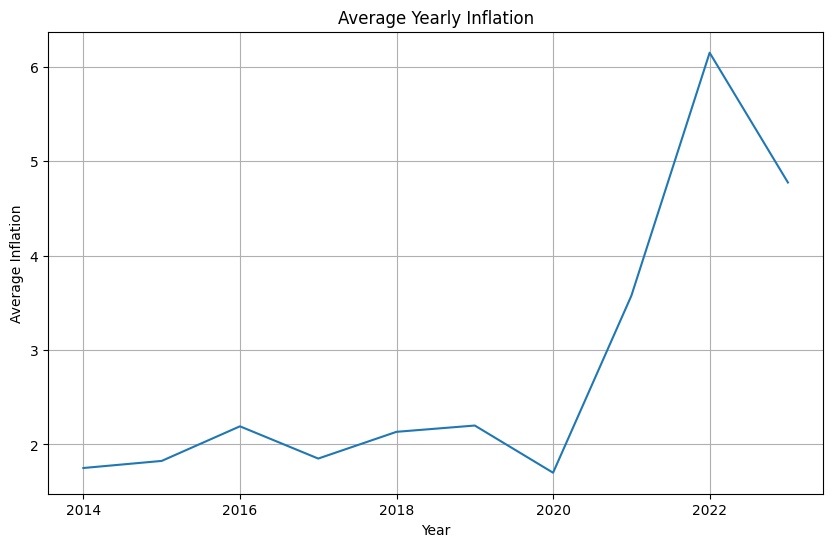

In [ ]:
# NBVAL_SKIP
import matplotlib.pyplot as plt
import pandas as pd

# Load data
df = pd.read_csv("/tmp/tmpvzjigv7g/n2OzlTWhinflation.csv")

# Calculate average yearly inflation
df['Average'] = df[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']].mean(axis=1)

# Plot average yearly inflation as a time series
plt.figure(figsize=(10,6))
plt.plot(df['Year'], df['Average'])
plt.title('Average Yearly Inflation')
plt.xlabel('Year')
plt.ylabel('Average Inflation')
plt.grid(True)
plt.show()

### 2.5. Using Model Context Protocol

In this example, we will show how tools hosted in an MCP server can be configured to be used by the model.

In the following steps, we will use the [filesystem tool](https://github.com/modelcontextprotocol/servers/tree/main/src/filesystem) to explore the files and folders available in the /content directory

Use xterm module to start a shell to run the MCP server using the `supergateway` tool which can start an MCP tool and serve it over HTTP.

In [8]:
!pip install colab-xterm #https://pypi.org/project/colab-xterm/
%load_ext colabxterm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/115.6 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.6/115.6 kB 4.2 MB/s eta 0:00:00


In [9]:

%xterm
# touch /content/foo
# touch /content/bar
# npx -y supergateway --port 8000 --stdio 'npx -y @modelcontextprotocol/server-filesystem /content'

Launching Xterm...

<IPython.core.display.Javascript object>

Register the toolgroup hosted in the MCP server with llama stack and verify if the stack discovers the tools correctly

In [10]:
from llama_stack_client.types.shared_params.url import URL
client.toolgroups.register(
    toolgroup_id="mcp::filesystem",
    provider_id="model-context-protocol",
    mcp_endpoint=URL(uri="http://localhost:8000/sse"),
)

In [11]:
pprint(client.tools.list(toolgroup_id="mcp::filesystem"))

[
│   Tool(
│   │   description='Read the complete contents of a file from the file system. Handles various text encodings and provides detailed error messages if the file cannot be read. Use this tool when you need to examine the contents of a single file. Only works within allowed directories.',
│   │   identifier='read_file',
│   │   parameters=[Parameter(description='', name='path', parameter_type='string', required=True, default=None)],
│   │   provider_id='model-context-protocol',
│   │   provider_resource_id='read_file',
│   │   tool_host='model_context_protocol',
│   │   toolgroup_id='mcp::filesystem',
│   │   type='tool',
│   │   metadata={'endpoint': 'http://localhost:8000/sse'}
│   ),
│   Tool(
│   │   description="Read the contents of multiple files simultaneously. This is more efficient than reading files one by one when you need to analyze or compare multiple files. Each file's content is returned with its path as a reference. Failed reads for individual files won't stop the entire operation. Only works within allowed directories.",
│   │   identifier='read_multiple_files',
│   │   parameters=[Parameter(description='', name='paths', parameter_type='array', required=True, default=None)],
│   │   provider_id='model-context-protocol',
│   │   provider_resource_id='read_multiple_files',
│   │   tool_host='model_context_protocol',
│   │   toolgroup_id='mcp::filesystem',
│   │   type='tool',
│   │   metadata={'endpoint': 'http://localhost:8000/sse'}
│   ),
│   Tool(
│   │   description='Create a new file or completely overwrite an existing file with new content. Use with caution as it will overwrite existing files without warning. Handles text content with proper encoding. Only works within allowed directories.',
│   │   identifier='write_file',
│   │   parameters=[
│   │   │   Parameter(description='', name='path', parameter_type='string', required=True, default=None),
│   │   │   Parameter(description='', name='content', parameter_type='string', required=True, default=None)
│   │   ],
│   │   provider_id='model-context-protocol',
│   │   provider_resource_id='write_file',
│   │   tool_host='model_context_protocol',
│   │   toolgroup_id='mcp::filesystem',
│   │   type='tool',
│   │   metadata={'endpoint': 'http://localhost:8000/sse'}
│   ),
│   Tool(
│   │   description='Make line-based edits to a text file. Each edit replaces exact line sequences with new content. Returns a git-style diff showing the changes made. Only works within allowed directories.',
│   │   identifier='edit_file',
│   │   parameters=[
│   │   │   Parameter(description='', name='path', parameter_type='string', required=True, default=None),
│   │   │   Parameter(description='', name='edits', parameter_type='array', required=True, default=None),
│   │   │   Parameter(
│   │   │   │   description='Preview changes using git-style diff format',
│   │   │   │   name='dryRun',
│   │   │   │   parameter_type='boolean',
│   │   │   │   required=True,
│   │   │   │   default=None
│   │   │   )
│   │   ],
│   │   provider_id='model-context-protocol',
│   │   provider_resource_id='edit_file',
│   │   tool_host='model_context_protocol',
│   │   toolgroup_id='mcp::filesystem',
│   │   type='tool',
│   │   metadata={'endpoint': 'http://localhost:8000/sse'}
│   ),
│   Tool(
│   │   description='Create a new directory or ensure a directory exists. Can create multiple nested directories in one operation. If the directory already exists, this operation will succeed silently. Perfect for setting up directory structures for projects or ensuring required paths exist. Only works within allowed directories.',
│   │   identifier='create_directory',
│   │   parameters=[Parameter(description='', name='path', parameter_type='string', required=True, default=None)],
│   │   provider_id='model-context-protocol',
│   │   provider_resource_id='create_directory',
│   │   tool_host='model_context_protocol',
│   │   toolgroup_id='mcp::filesystem',
│   │   type='tool',
│   │   metad

In [12]:
from llama_stack_client.lib.agents.agent import Agent
from llama_stack_client.lib.agents.event_logger import EventLogger
from llama_stack_client.types.agent_create_params import AgentConfig
from termcolor import cprint

agent_config = AgentConfig(
    model=model_id,
    instructions="You are a helpful assistant",
    toolgroups=["mcp::filesystem"],
    input_shields=[],
    output_shields=[],
    enable_session_persistence=False,
)
agent = Agent(client, agent_config)
user_prompts = [
    "Hello",
    "list all the files /content",
]

session_id = agent.create_session("test-session")
for prompt in user_prompts:
    cprint(f"User> {prompt}", "green")
    response = agent.create_turn(
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        session_id=session_id,
    )
    for log in EventLogger().log(response):
        log.print()


User> Hello
inference> None of the provided functions can be used to respond to a greeting.
User> list all the files /content
inference> {"type": "function", "name": "list_directory", "parameters": {"path": "/content"}}
tool_execution> Tool:list_directory Args:{'path': '/content'}
tool_execution> Tool:list_directory Response:{"type":"text","text":"[DIR] .config\n[FILE] bar\n[FILE] foo\n[DIR] sample_data"}
inference> {"type": "function", "name": "list_directory", "parameters": {"path": "/content"}}
tool_execution> Tool:list_directory Args:{'path': '/content'}
tool_execution> Tool:list_directory Response:{"type":"text","text":"[DIR] .config\n[FILE] bar\n[FILE] foo\n[DIR] sample_data"}
inference> The list of files in the /content directory is:

[DIR] .config
[FILE] bar
[FILE] foo
[DIR] sample_data


## 3. Llama Stack Agent Evaluations


#### 3.1. Online Evaluation Dataset Collection Using Telemetry

- Llama Stack offers built-in telemetry to collect traces and data about your agentic application.
- In this example, we will show how to build an Agent with Llama Stack, and query the agent's traces into an online dataset that can be used for evaluation.  

##### 3.1.1. Building a Search Agent

In [18]:
# NBVAL_SKIP
from llama_stack_client.lib.agents.agent import Agent
from llama_stack_client.lib.agents.event_logger import EventLogger
from llama_stack_client.types.agent_create_params import AgentConfig

agent_config = AgentConfig(
    model="meta-llama/Llama-3.1-405B-Instruct-FP8",
    instructions="You are a helpful assistant. Use search tool to answer the questions. ",
    toolgroups=["builtin::websearch"],
    input_shields=[],
    output_shields=[],
    enable_session_persistence=False,
)
agent = Agent(client, agent_config)
user_prompts = [
    "Which teams played in the NBA western conference finals of 2024",
    "In which episode and season of South Park does Bill Cosby (BSM-471) first appear? Give me the number and title.",
    "What is the British-American kickboxer Andrew Tate's kickboxing name?",
]

session_id = agent.create_session("test-session")

for prompt in user_prompts:
    response = agent.create_turn(
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        session_id=session_id,
    )

    for log in EventLogger().log(response):
        log.print()


inference> brave_search.call(query="NBA Western Conference Finals 2024 teams")
tool_execution> Tool:brave_search Args:{'query': 'NBA Western Conference Finals 2024 teams'}
tool_execution> Tool:brave_search Response:{"query": "NBA Western Conference Finals 2024 teams", "top_k": [{"title": "2024 NBA Western Conference Finals - Basketball-Reference.com", "url": "https://www.basketball-reference.com/playoffs/2024-nba-western-conference-finals-mavericks-vs-timberwolves.html", "content": "2024 NBA Western Conference Finals Mavericks vs. Timberwolves League Champion: Boston Celtics. Finals MVP: Jaylen Brown (20.8 / 5.4 / 5.0) 2024 Playoff Leaders: PTS: Luka Don\u010di\u0107 (635) TRB: Luka Don\u010di\u0107 (208) AST: Luka Don\u010di\u0107 (178) WS: Derrick White (2.9) More playoffs info", "score": 0.9310187, "raw_content": null}, {"title": "NBA Western Conference Finals 2024: Dates, schedule and more - Sportskeeda", "url": "https://www.sportskeeda.com/basketball/news-nba-western-conference-fi

##### 3.1.2 Query Telemetry

In [19]:
# NBVAL_SKIP
print(f"Getting traces for session_id={session_id}")
import json

from rich.pretty import pprint

agent_logs = []

for span in client.telemetry.query_spans(
    attribute_filters=[
        {"key": "session_id", "op": "eq", "value": session_id},
    ],
    attributes_to_return=["input", "output"],
):
    if span.attributes["output"] != "no shields":
        agent_logs.append(span.attributes)

pprint(agent_logs)


Getting traces for session_id=72993b3e-6030-44f5-9f48-664449d2b6d3


[
│   {
│   │   'input': [
│   │   │   '{"role":"system","content":"You are a helpful assistant. Use search tool to answer the questions. "}',
│   │   │   '{"role":"user","content":"Which teams played in the NBA western conference finals of 2024","context":null}'
│   │   ],
│   │   'output': "content:  tool_calls: [ToolCall(call_id='8b7294ec-a83f-4798-ad8f-6bed662f08b6', tool_name=<BuiltinTool.brave_search: 'brave_search'>, arguments={'query': 'NBA Western Conference Finals 2024 teams'})]"
│   },
│   {
│   │   'input': '{"role":"assistant","content":"","stop_reason":"end_of_turn","tool_calls":[{"call_id":"8b7294ec-a83f-4798-ad8f-6bed662f08b6","tool_name":"brave_search","arguments":{"query":"NBA Western Conference Finals 2024 teams"}}]}',
│   │   'output': '{"role":"tool","call_id":"8b7294ec-a83f-4798-ad8f-6bed662f08b6","tool_name":"brave_search","content":"{\\"query\\": \\"NBA Western Conference Finals 2024 teams\\", \\"top_k\\": [{\\"title\\": \\"2024 NBA Western Conference Finals - Basketball-Reference.com\\", \\"url\\": \\"https://www.basketball-reference.com/playoffs/2024-nba-western-conference-finals-mavericks-vs-timberwolves.html\\", \\"content\\": \\"2024 NBA Western Conference Finals Mavericks vs. Timberwolves League Champion: Boston Celtics. Finals MVP: Jaylen Brown (20.8 / 5.4 / 5.0) 2024 Playoff Leaders: PTS: Luka Don\\\\u010di\\\\u0107 (635) TRB: Luka Don\\\\u010di\\\\u0107 (208) AST: Luka Don\\\\u010di\\\\u0107 (178) WS: Derrick White (2.9) More playoffs info\\", \\"score\\": 0.9310187, \\"raw_content\\": null}, {\\"title\\": \\"NBA Western Conference Finals 2024: Dates, schedule and more - Sportskeeda\\", \\"url\\": \\"https://www.sportskeeda.com/basketball/news-nba-western-conference-finals-2024-dates-schedule-and-more\\", \\"content\\": \\"NBA Western Conference Finals 2024: Dates & Schedule The 2023-24 NBA Western Conference Finals will start on Wednesday, May 22. The Mavericks will face the team that wins in Game 7 between the\\", \\"score\\": 0.8914433, \\"raw_content\\": null}, {\\"title\\": \\"2024 Playoffs: West Finals | Timberwolves (3) vs. Mavericks (5) - NBA.com\\", \\"url\\": \\"https://www.nba.com/playoffs/2024/west-final\\", \\"content\\": \\"The Dallas Mavericks and Minnesota Timberwolves have advanced to the 2024 Western Conference Finals during the NBA playoffs.\\", \\"score\\": 0.8884594, \\"raw_content\\": null}, {\\"title\\": \\"2024 NBA Western Conference playoff bracket - Basketnews.com\\", \\"url\\": \\"https://basketnews.com/news-204687-2024-nba-western-conference-playoff-bracket.html\\", \\"content\\": \\"In the 2024 NBA Western Conference playoffs, the Oklahoma City Thunder clinched the No. 1 seed. Every team from the Western Conference played their final game of the regular season, and two playoff pairs have been confirmed. The Los Angeles Lakers beat the New Orleans Pelicans, 110-106, in the Play-In Tournament to secure the 7th seed to set up a first-round matchup with the Denver Nuggets. Meanwhile, the Sacramento Kings will host the Golden State Warriors in the second Western Conference NBA Play-In Tournament game. The winners secure the No. 8 seed in the NBA playoffs for its conference. EuroLeague Play-In: Baskonia-Virtus game schedule announced\\", \\"score\\": 0.8479807, \\"raw_content\\": null}, {\\"title\\": \\"NBA Finals 2024 - Celtics-Mavericks news, schedule, scores and ... - ESPN\\", \\"url\\": \\"https://www.espn.com/nba/story/_/id/39943302/nba-playoffs-2024-conference-finals-news-scores-highlights\\", \\"content\\": \\"The Boston Celtics are the 2024 NBA Champions. ... Western Conference. Final 2023-24 NBA regular-season standings. Which team left standing has the most trips to the NBA Finals? Here is a look at\\", \\"score\\": 0.81979275, \\"raw_content\\": null}]}"}'
│   },
│   {
│   │   'input': [
│   │   │   '{"role":"system","content":"You are a helpful assistant. Use search tool to answer the questions. "}',
│   │   │   '{"role":"user","content":"Which teams played in

##### 3.1.3 Post-Process Telemetry Results & Evaluate

- Now, we want to run evaluation to assert that our search agent succesfully calls brave_search from online traces.
- We will first post-process the agent's telemetry logs and run evaluation.

In [17]:
# NBVAL_SKIP
# post-process telemetry spance and prepare data for eval
# in this case, we want to assert that all user prompts is followed by a tool call
import ast
import json

eval_rows = []

for log in agent_logs:
    print(log)
    last_msg = log["input"][-1]
    if '"role":"user"' in last_msg:
        eval_rows.append(
            {
                "input_query": last_msg,
                "generated_answer": log["output"],
                # check if generated_answer uses tools brave_search
                "expected_answer": "brave_search",
            },
        )

pprint(eval_rows)
scoring_params = {
    "basic::subset_of": None,
}
scoring_response = client.scoring.score(
    input_rows=eval_rows, scoring_functions=scoring_params
)
pprint(scoring_response)


{'input': ['{"role":"system","content":"You are a helpful assistant. Use search tool to answer the questions. "}', '{"role":"user","content":"Which teams played in the NBA western conference finals of 2024","context":null}'], 'output': 'content: Let me check the latest sports news. tool_calls: []'}
{'input': ['{"role":"system","content":"You are a helpful assistant. Use search tool to answer the questions. "}', '{"role":"user","content":"Which teams played in the NBA western conference finals of 2024","context":null}', '{"role":"assistant","content":"Let me check the latest sports news.","stop_reason":"end_of_turn","tool_calls":[]}', '{"role":"user","content":"In which episode and season of South Park does Bill Cosby (BSM-471) first appear? Give me the number and title.","context":null}'], 'output': "content:  tool_calls: [ToolCall(call_id='26345b28-7f75-401e-88e3-77933cb70a2e', tool_name=<BuiltinTool.brave_search: 'brave_search'>, arguments={'query': 'Bill Cosby South Park episode'})]

[
│   {
│   │   'input_query': '{"role":"user","content":"Which teams played in the NBA western conference finals of 2024","context":null}',
│   │   'generated_answer': 'content: Let me check the latest sports news. tool_calls: []',
│   │   'expected_answer': 'brave_search'
│   },
│   {
│   │   'input_query': '{"role":"user","content":"In which episode and season of South Park does Bill Cosby (BSM-471) first appear? Give me the number and title.","context":null}',
│   │   'generated_answer': "content:  tool_calls: [ToolCall(call_id='26345b28-7f75-401e-88e3-77933cb70a2e', tool_name=<BuiltinTool.brave_search: 'brave_search'>, arguments={'query': 'Bill Cosby South Park episode'})]",
│   │   'expected_answer': 'brave_search'
│   },
│   {
│   │   'input_query': '{"role":"user","content":"What is the British-American kickboxer Andrew Tate\'s kickboxing name?","context":null}',
│   │   'generated_answer': "content:  tool_calls: [ToolCall(call_id='fd4cc3c6-49d0-42e4-b0af-877e72f8d6ba', tool_name=<BuiltinTool.brave_search: 'brave_search'>, arguments={'query': 'Andrew Tate kickboxing name'})]",
│   │   'expected_answer': 'brave_search'
│   }
]

ScoringScoreResponse(
│   results={
│   │   'basic::subset_of': ScoringResult(
│   │   │   aggregated_results={'accuracy': {'accuracy': 0.6666666666666666, 'num_correct': 2.0, 'num_total': 3}},
│   │   │   score_rows=[{'score': 0.0}, {'score': 1.0}, {'score': 1.0}]
│   │   )
│   }
)

#### 3.2. Agentic Application Dataset Scoring
- Llama Stack offers a library of scoring functions and the `/scoring` API, allowing you to run evaluations on your pre-annotated AI application datasets.

- In this example, we will work with an example RAG dataset you have built previously, label with an annotation, and use LLM-As-Judge with custom judge prompt for scoring. Please checkout our [Llama Stack Playground](https://llama-stack.readthedocs.io/en/latest/playground/index.html) for an interactive interface to upload datasets and run scorings.

In [ ]:
# NBVAL_SKIP
import rich
from rich.pretty import pprint

judge_model_id = "meta-llama/Llama-3.1-405B-Instruct-FP8"

JUDGE_PROMPT = """
Given a QUESTION and GENERATED_RESPONSE and EXPECTED_RESPONSE.

Compare the factual content of the GENERATED_RESPONSE with the EXPECTED_RESPONSE. Ignore any differences in style, grammar, or punctuation.
  The GENERATED_RESPONSE may either be a subset or superset of the EXPECTED_RESPONSE, or it may conflict with it. Determine which case applies. Answer the question by selecting one of the following options:
  (A) The GENERATED_RESPONSE is a subset of the EXPECTED_RESPONSE and is fully consistent with it.
  (B) The GENERATED_RESPONSE is a superset of the EXPECTED_RESPONSE and is fully consistent with it.
  (C) The GENERATED_RESPONSE contains all the same details as the EXPECTED_RESPONSE.
  (D) There is a disagreement between the GENERATED_RESPONSE and the EXPECTED_RESPONSE.
  (E) The answers differ, but these differences don't matter from the perspective of factuality.

Give your answer in the format "Answer: One of ABCDE, Explanation: ".

Your actual task:

QUESTION: {input_query}
GENERATED_RESPONSE: {generated_answer}
EXPECTED_RESPONSE: {expected_answer}
"""

input_query = (
    "What are the top 5 topics that were explained? Only list succinct bullet points."
)
generated_answer = """
Here are the top 5 topics that were explained in the documentation for Torchtune:

* What is LoRA and how does it work?
* Fine-tuning with LoRA: memory savings and parameter-efficient finetuning
* Running a LoRA finetune with Torchtune: overview and recipe
* Experimenting with different LoRA configurations: rank, alpha, and attention modules
* LoRA finetuning
"""
expected_answer = """LoRA"""

rows = [
    {
        "input_query": input_query,
        "generated_answer": generated_answer,
        "expected_answer": expected_answer,
    },
]

scoring_params = {
    "llm-as-judge::base": {
        "judge_model": judge_model_id,
        "prompt_template": JUDGE_PROMPT,
        "type": "llm_as_judge",
        "judge_score_regexes": ["Answer: (A|B|C|D|E)"],
    },
    "basic::subset_of": None,
}

response = client.scoring.score(input_rows=rows, scoring_functions=scoring_params)
pprint(response)


ScoringScoreResponse(
│   results={
│   │   'llm-as-judge::base': ScoringResult(
│   │   │   aggregated_results={},
│   │   │   score_rows=[
│   │   │   │   {
│   │   │   │   │   'score': 'B',
│   │   │   │   │   'judge_feedback': 'Answer: B, Explanation: The GENERATED_RESPONSE is a superset of the EXPECTED_RESPONSE and is fully consistent with it. The EXPECTED_RESPONSE only mentions "LoRA", which is present in all the points of the GENERATED_RESPONSE. The GENERATED_RESPONSE provides more details and specific topics related to LoRA, but it does not contradict the EXPECTED_RESPONSE.'
│   │   │   │   }
│   │   │   ]
│   │   ),
│   │   'basic::subset_of': ScoringResult(
│   │   │   aggregated_results={'accuracy': {'accuracy': 1.0, 'num_correct': 1.0, 'num_total': 1}},
│   │   │   score_rows=[{'score': 1.0}]
│   │   )
│   }
)